## Cel pracy

Celem projektu jest znalezienie potencjalnych darczyńców w zbiorze danych, który jest spisem powszechnym ludności w USA z 1994 roku. W ramach projektu wykorzystam różnego rodzaju algorytmy uczenia maszynowego oprate na uczeniu nadzorowanym w celu zaprognozowania dochodu osób z subsetu. W kolejnym etapie wybiorę algorytm o największej skuteczności/precyzji. 
Zakładam, że potencjalni darczyńcy to osoby, która zarabiają ponad 50 000 $. Podstawą pracy będzie eksploracja danych i znalezienie cech, które w najwięszym stopniu determinują osiągany dochód. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = "{:.3f}".format
pd.set_option('display.max_columns',100)

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6
sns.set(style='white')

In [10]:
# Funckje

def counts_pct(category,data):
    '''Funkcja, która zwraca dla tanej kategori liczbe wartości, oraz wartość procentową'''
    base = data[category].value_counts()
    pct = base/data[category].shape[0] * 100
    joined = pd.concat([base,pct],axis=1)
    joined.columns = [str(category),str(category) + ' %']
    return joined


def annotate(ax,s="%.2f",suffix=''):
    for p in ax.patches:
        ax.annotate(s % p.get_height() + suffix, 
                 (p.get_x() + p.get_width() / 2,
                  p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
        
def despine(rot=0):
    sns.despine(left=True)
    plt.xticks(rotation = rot);
    plt.xlabel('');
    plt.ylabel('');

In [2]:
data = pd.read_csv('census.csv')

In [3]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.000,Never-married,Adm-clerical,Not-in-family,White,Male,2174.000,0.000,40.000,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000,0.000,13.000,United-States,<=50K
2,38,Private,HS-grad,9.000,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000,0.000,40.000,United-States,<=50K
3,53,Private,11th,7.000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000,0.000,40.000,United-States,<=50K
4,28,Private,Bachelors,13.000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000,0.000,40.000,Cuba,<=50K


In [4]:
data.shape

(45222, 14)

## Dataset Informacje

Zbiór danych pochodzi ze strony https://archive.ics.uci.edu/ml/datasets/census+income

Jest to spis powszechny ludności w USA z 1994 roku, w którym mamy cechy społeczno ekonomiczne każdej osoby oraz informacje o dochodzie. 

Zbiór danych liczy 45222 wiersze oraz 14 cech.


### Zmienne  

__age:__ Age  
__workclass__: Working Class (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked)  
__education_level__: Level of Education (Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool)  
__education-num__: Number of educational years completed  
__marital-status__: Marital status (Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse)  
__occupation:__ Work Occupation (Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces)  
__relationship__: Relationship Status (Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried)  
__race:__ Race (White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black)  
__sex:__ Sex (Female, Male)  
__capital-gain:__ Monetary Capital Gains  
__capital-loss:__ Monetary Capital Losses  
__hours-per-week:__ Average Hours Per Week Worked  
__native-country:__ Native Country (United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands)  

__income:__ Income Class (<=50K, >50K) - Target  

In [6]:
data.isnull().sum()

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

Nie mamy w naszym zbiorze danych, rzadnych brakujących danych. Więc możemy przejść do ekslporacji danych

### Eksploracja i wizualizacja danych

In [11]:
counts_pct(category='income',data=data)

,income,income %
<=50K,34014,75.216
>50K,11208,24.784


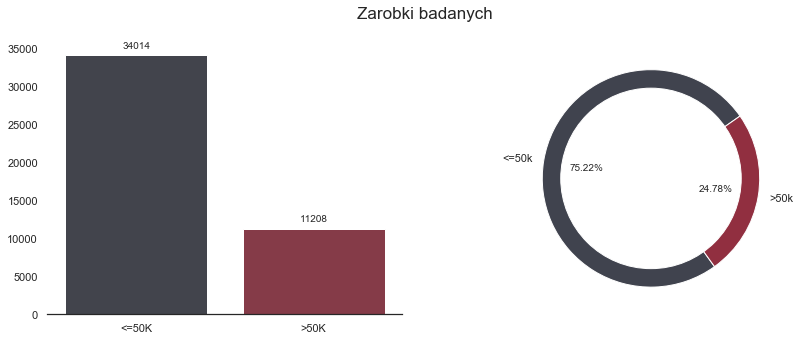

In [18]:
f,ax = plt.subplots(1,2,figsize=(14,5))
fig1 = sns.barplot(y='income', x=counts_pct(category='income',data=data).index 
                   ,data= counts_pct(category='income',data=data)
                  ,palette=['#40434E','#912F40'],ax=ax[0])
fig1.set_ylabel('');
annotate(fig1,s="%.0f",suffix='')
despine()

my_circle=plt.Circle( (0,0), 0.83, color='white')
names=['<=50k','>50k']
size=data['income'].value_counts().tolist()
plt.pie(size, labels=names, colors=['#40434E','#912F40'],autopct='%1.2f%%',startangle=35)
p=plt.gcf()
p.gca().add_artist(my_circle);
plt.setp(plt.gcf().get_axes(), xlabel='', ylabel='');
plt.suptitle('Zarobki badanych', fontsize=17);

Widzimy, ze w naszym zbiorze danych 75% stanowią, osoby zarabiające mniej niż 50 000 USD, pozostałe 25 % zarabia więcej niż 50 000 USD

### Przygotowanie danych

Jednym z podstawowych działań przed przystąpieniem do budowania modelu jest wstępne przetworzenie danych. Etap ten obejmuje m.in czyszczenie danych, formatowanie danych, zmianę struktury danych itd. 
Zbiór danych może czasem zawierać cechy, których dytrybucja oscyluje wokół danego punktu (liczby, wartości) jednak może również zawierać znaczną część wartości, które leżą daleko od tego punktu. Algorytmy mogą być wrażliwe na takie rozkłady wartości i mogą osiągać gorsze wyniki. W takim wypadku zazwyczaj stosuje się metody normalizacji. 

Czym jest skośność ? 

Skośność jest miarą asymetrii obserwowanych wyników. Informuje nas o tym jak wyniki dla danej zmiennej kształtują się wokół średniej. Czy większość zaobserwowanych wyników jest z lewej strony średniej, blisko wartości średniej czy z prawej strony średniej? Innymi słowy, czy w naszym zbiorze obserwacji więcej jest wyników, które są niższe niż średnia dla całej grupy, wyższe czy równe średniej?

![Image of skośność](https://consider.pl/wp-content/uploads/2014/11/kurtoza_skosnosc.jpg)

1. Rozkład normalny jest idealnie symetryczny. Występuje tu zależność __Średnia= Mediana= Dominanta__ Oznacza to, że wartość średnia dzieli rozkład dokładnie na pół i jest też najczęściej występującą wartością.

2. Rozkład prawoskośny cechuje się natomiast długim tzw. „ogonem” z prawej strony rozkładu. __Średnia > Mediana > Dominanta__
Oznacza to, że w próbie badawczej jest więcej wyników poniżej średniej.

3. W rozkładzie lewoskośnym występuje natomiast długi ogon z lewej strony rozkładu. . Zachodzi w nim zależność: __Średnia < Mediana < Dominanta__

Poza skośnością rozkładu bardzo ważna jest również kurtoza określająca drugi wymiar zmiany rozkładu, jego spłaszczenie lub wysmuklenie. Kurtoza wraz ze skośnością są miarami pozwalającymi określić czy rozkład jest zgodny z rozkładem normalnym lub czy występują istotne różnice między badanym rozkładem a rozkładem normalnym.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


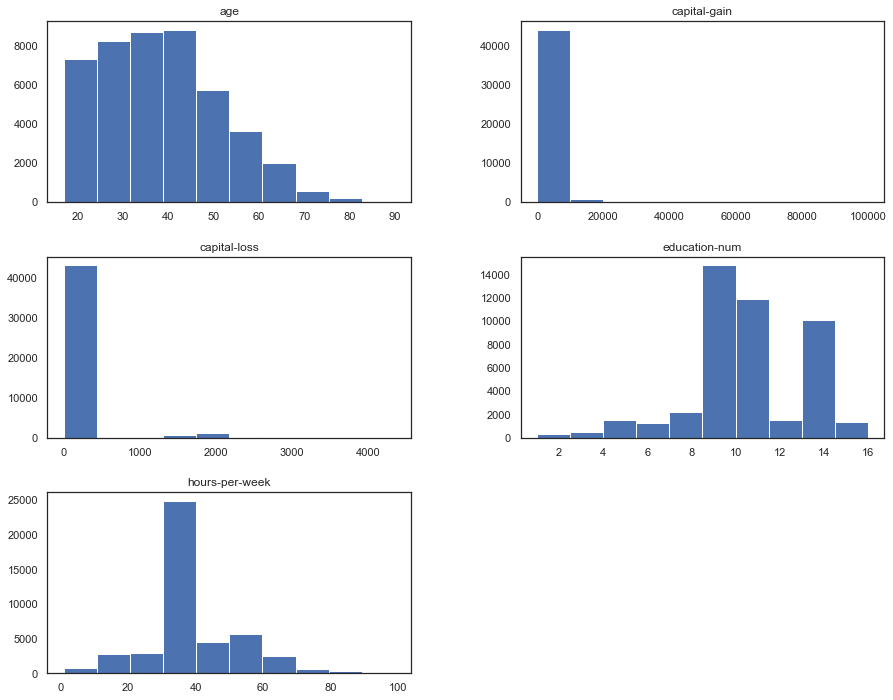

In [28]:
# kategorie capital-gain, capital-loss , hours-per-week ,   age  , education-num
features_sk = ['capital-gain','capital-loss','age','education-num','hours-per-week']

data[features_sk].hist(figsize=(15,12),grid=False);

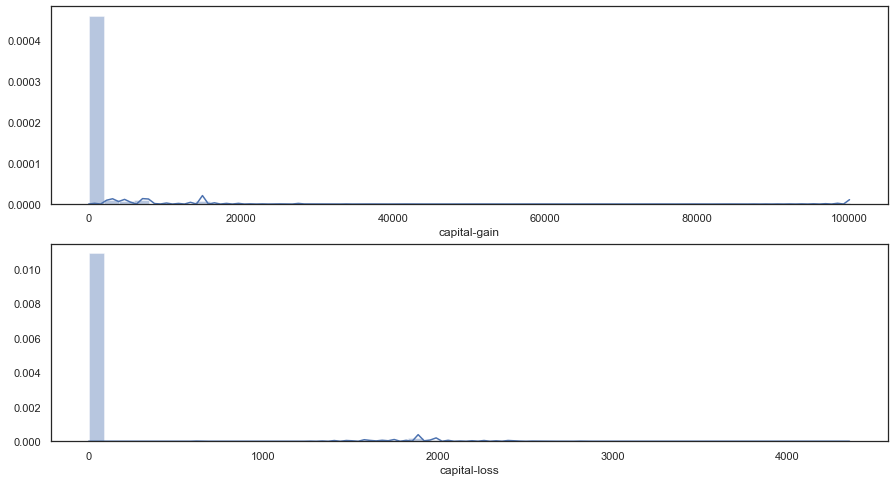

In [37]:
f,ax = plt.subplots(2,1,figsize=(15,8))
a1 = sns.distplot(data['capital-gain'],ax=ax[0])
a2 = sns.distplot(data['capital-loss'],ax=ax[1])

In [38]:
data[features_sk].skew()

capital-gain     11.789
capital-loss      4.516
age               0.533
education-num    -0.311
hours-per-week    0.341
dtype: float64

W przypadku capital-gain i capital-loss mamy doczyniennia z asymtrią i dużą skośnością prawostronną. Powinniśmy dokonać normalizacji danych